## Random forest

In [19]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np

import warnings
warnings.filterwarnings('ignore')

housing = pd.read_csv('housing.csv')

housing = pd.get_dummies(housing, drop_first=True)
target = 'median_house_value'
X = housing.copy().drop(target, axis=1)
y = housing[target]

### Concepto total de variables

Árbol normal

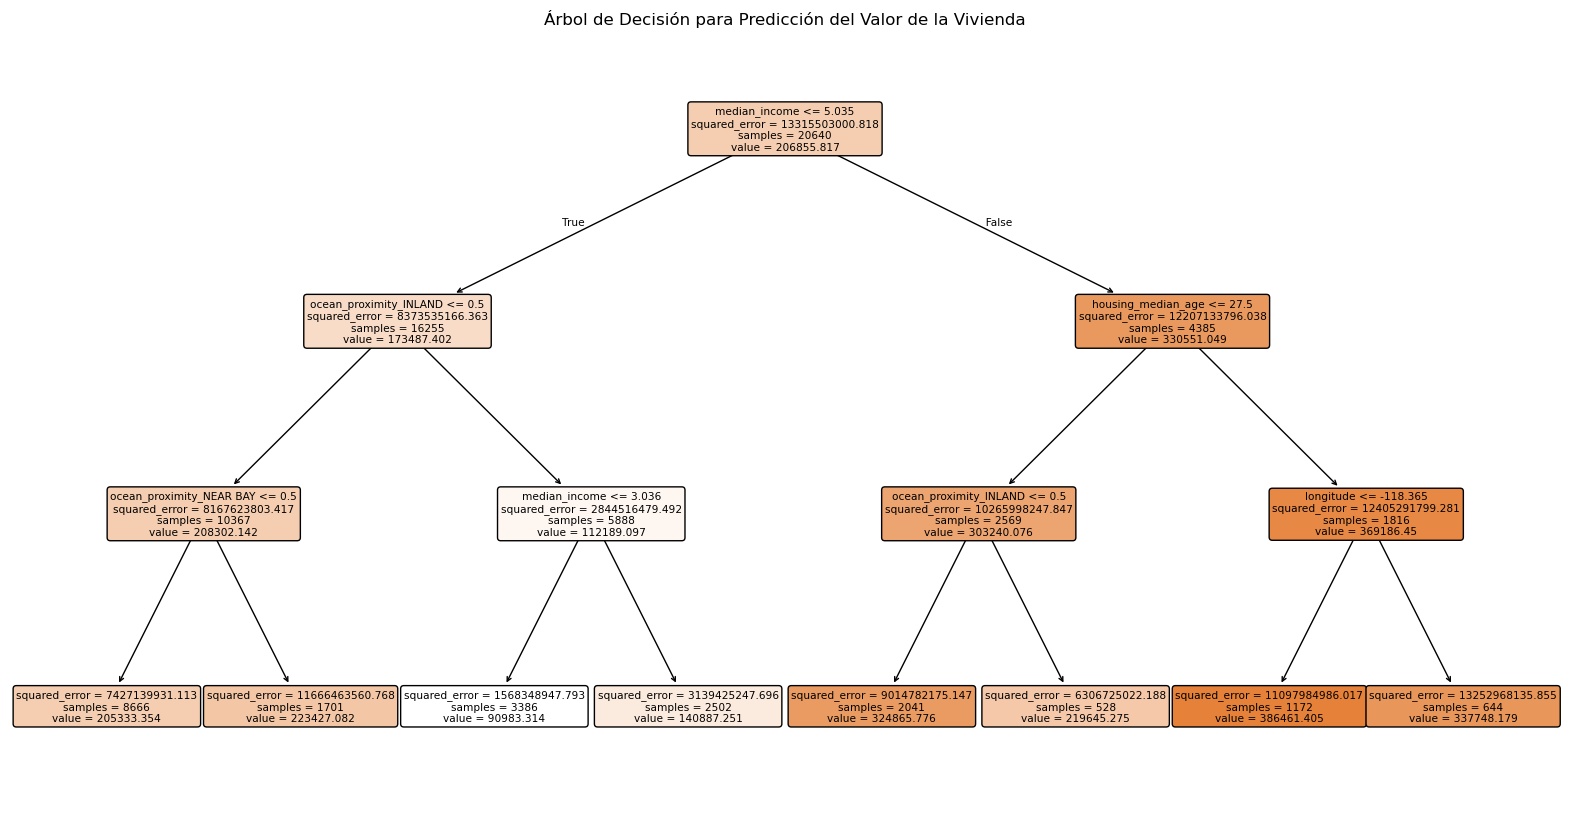

In [2]:
# Train model    
model = DecisionTreeRegressor(max_depth=3, random_state=42, 
                                  max_features='sqrt')
model.fit(X, y)

plt.figure(figsize=(20, 10)) 
plot_tree(model, feature_names=X.keys(), filled=True, rounded=True)
plt.title("Árbol de Decisión para Predicción del Valor de la Vivienda")
plt.show()

### Maximo 3 features

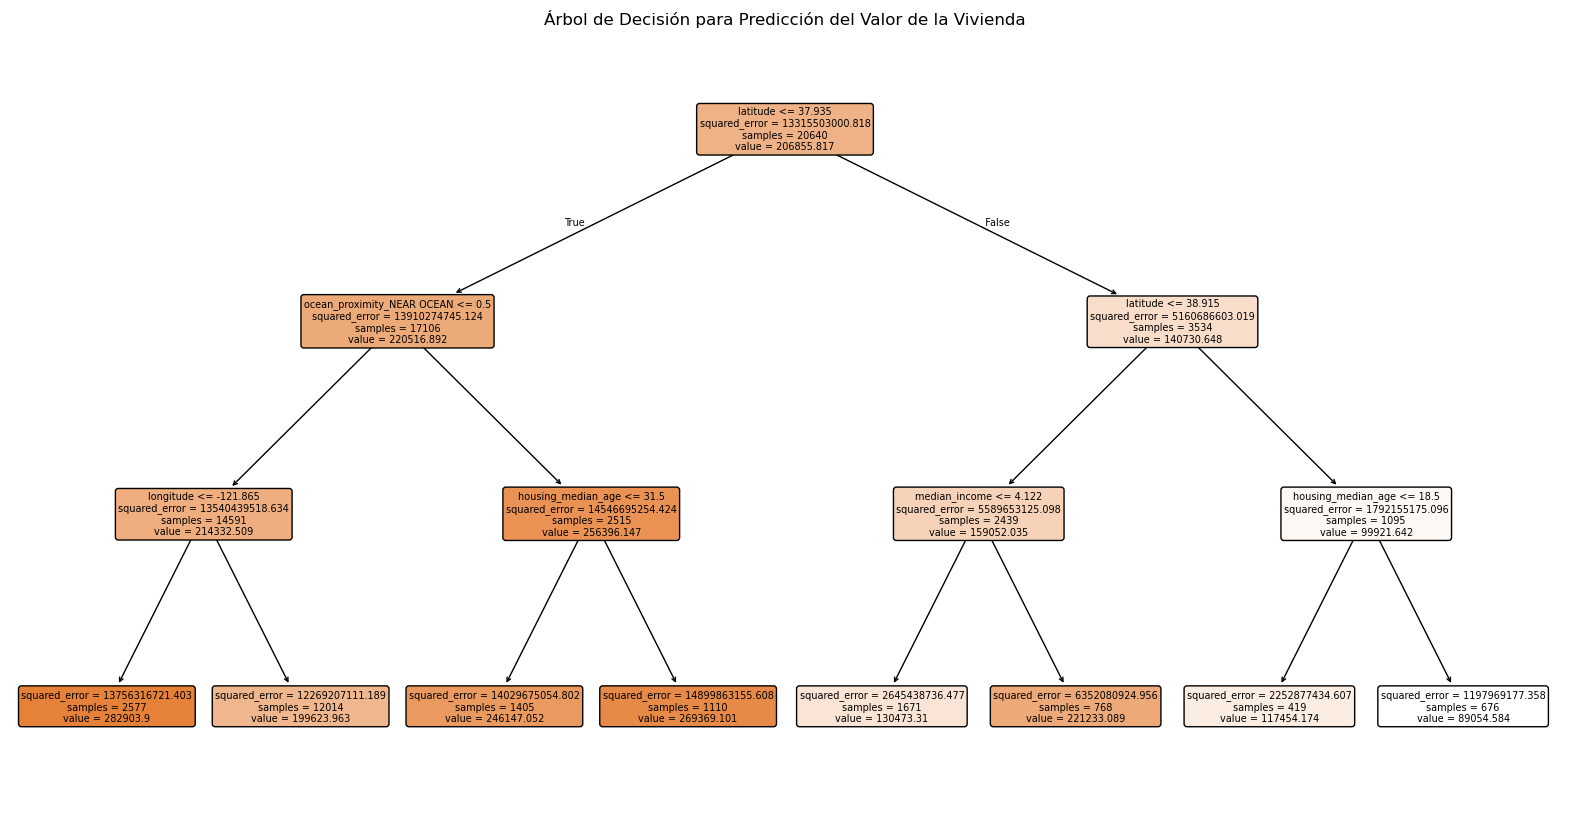

In [5]:
# Crear y entrenar el modelo de árbol de decisión
# Train model    
model = DecisionTreeRegressor(max_depth=3, random_state=2, 
                                  max_features=2)
model.fit(X, y)

plt.figure(figsize=(20, 10)) 
plot_tree(model, feature_names=X.keys(), filled=True, rounded=True)
plt.title("Árbol de Decisión para Predicción del Valor de la Vivienda")
plt.show()

### Maximo 2 features


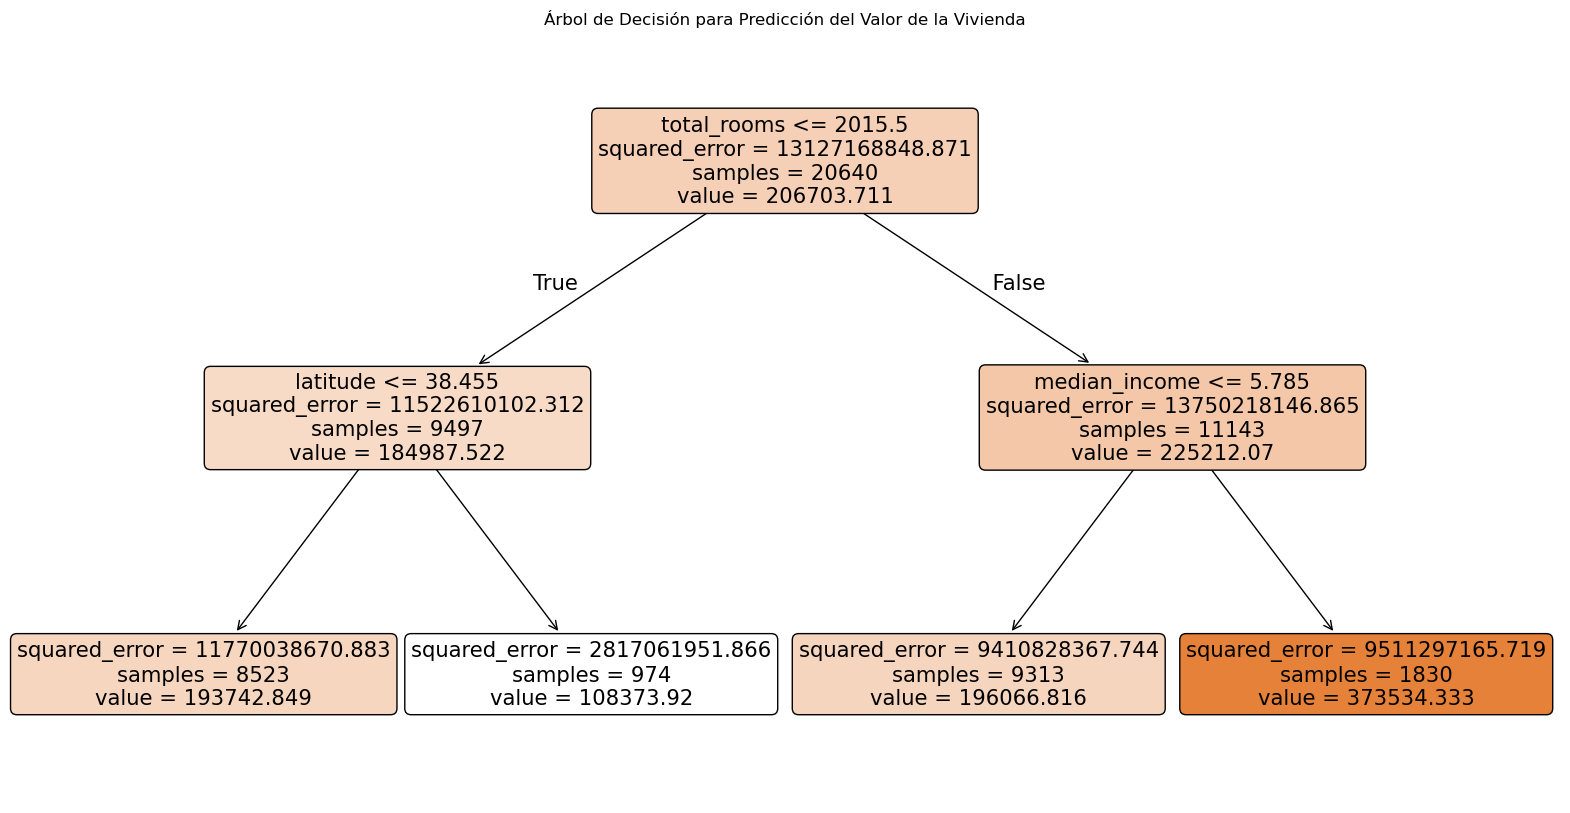

In [6]:
# Crear y entrenar el modelo de árbol de decisión

bootstrap_housing = housing.sample(len(housing), replace=True)
X = bootstrap_housing.drop(target, axis=1)
y = bootstrap_housing[target]


model = DecisionTreeRegressor(max_depth=2, random_state=1, 
                                  max_features='sqrt')
model.fit(X, y)

plt.figure(figsize=(20, 10)) 
plot_tree(model, feature_names=X.keys(), filled=True, rounded=True)
plt.title("Árbol de Decisión para Predicción del Valor de la Vivienda")
plt.show()

### Crea un bosque 

In [9]:
random_states = np.linspace(1, 100, 100)

In [20]:
# X train y test
# Dividir en entrenamiento y prueba

test_bootstrap = housing.sample(300)
X_sample = test_bootstrap.drop(target, axis=1)
y_sample = test_bootstrap[target]

df_predicciones = pd.DataFrame()

for i in range(100):
    bootstrap_housing = housing.sample(len(housing), replace=True)
    X = bootstrap_housing.drop(target, axis=1)
    y = bootstrap_housing[target]
    model = DecisionTreeRegressor(max_depth=8, random_state=i, 
                                  max_features='sqrt')
    model.fit(X, y)

    prediccion = model.predict(X_sample)
    df_predicciones['prediccion_'+str(i)] = prediccion

In [25]:
for i in range(100):
    bootstrap_housing = housing.sample(len(housing), replace=True)
    X = bootstrap_housing.drop(target, axis=1)
    y = bootstrap_housing[target]
    df_predicciones['prediccion_'+str(i)] = DecisionTreeRegressor(max_depth=8, random_state=i, max_features='sqrt').fit(X, y).predict(X_sample)

In [26]:
predicciones_rf = df_predicciones.mean(axis=1)

In [27]:
from sklearn.metrics import r2_score
r2_score(y_pred=predicciones_rf, y_true=y_sample)

0.7801154169083884

### Usando Sklearn

In [23]:
from sklearn.ensemble import RandomForestRegressor

housing = pd.read_csv('housing.csv')
housing = housing.fillna(-1)
housing = pd.get_dummies(housing, drop_first=True)
target = 'median_house_value'
X = housing.copy().drop(target, axis=1)
y = housing[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [28]:
# Grid search 
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=300, n_jobs=-1))
])

params = {
    'rf__max_depth': [8, 10, 15],
    'rf__max_features': ['sqrt', 'log2', 10, len(X_train.keys())]
}

rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=300,
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [8, 10, 15],
                         'rf__max_features': ['sqrt', 'log2', 10, 12]},
             scoring='r2')

In [29]:
rf_grid.best_params_

{'rf__max_depth': 15, 'rf__max_features': 10}

In [30]:
best_model = rf_grid.best_estimator_.named_steps['rf']

In [32]:
predicciones_rf = best_model.predict(X_test)

r2_score(y_pred=predicciones_rf, y_true=y_test)

0.8140223928742304

In [33]:
# Comparar con regresion lineal 
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)
predicciones_lr = model.predict(X_test)
r2_score(y_pred=predicciones_lr, y_true=y_test)

0.614606135909515

In [40]:
model_interpretability = pd.DataFrame({
    'variable': X_train.keys(),
    'importance': best_model.feature_importances_
})
model_interpretability

,variable,importance
0,longitude,0.106428
1,latitude,0.100042
2,housing_median_age,0.048559
3,total_rooms,0.021557
4,total_bedrooms,0.021936
5,population,0.029643
6,households,0.016891
7,median_income,0.486543
8,ocean_proximity_INLAND,0.158405
9,ocean_proximity_ISLAND,0.000312


In [34]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'blue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'red')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

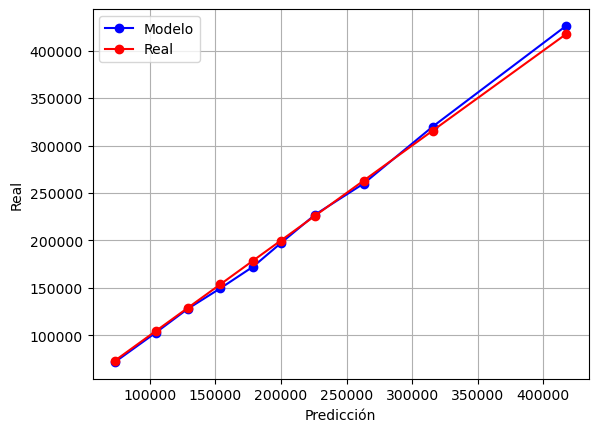

In [52]:
calibracion(predicciones_rf, y_test, 10)

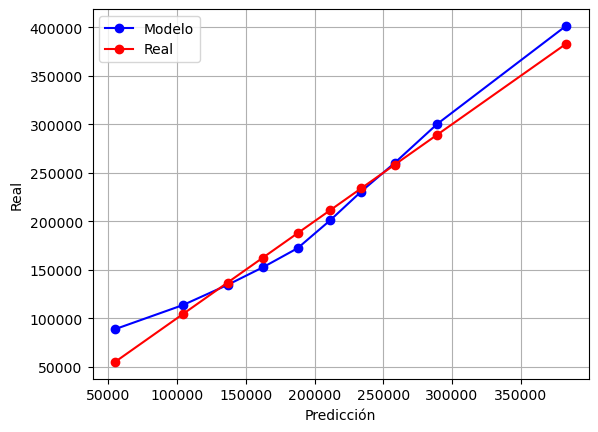

In [36]:
calibracion(predicciones_lr, y_test, 10)

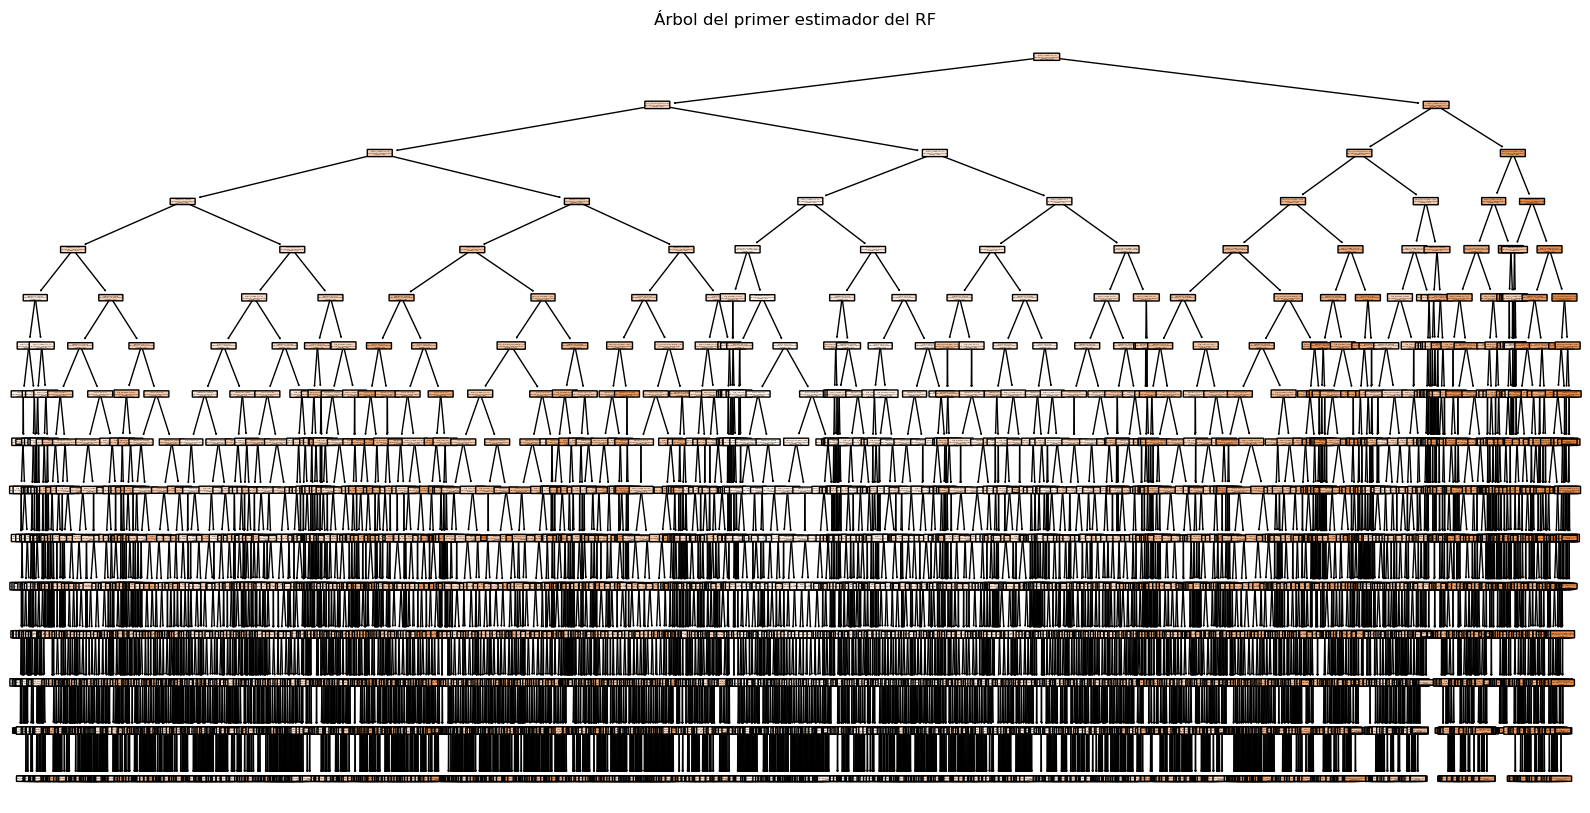

In [38]:
plt.figure(figsize=(20, 10)) 
plot_tree(best_model.estimators_[0], feature_names=X_train.keys(), filled=True, rounded=True)
plt.title("Árbol del primer estimador del RF")
plt.show()

# Interpretacion del modelo

## Partial dependence plot


Un Partial Dependence Plot (PDP) muestra la relación entre una o más características y la predicción de un modelo, manteniendo las demás variables fijas. Es útil para entender cómo un modelo como un Random Forest toma decisiones.

fig, ax = plt.subplots(figsize=(8, 5))

PartialDependenceDisplay.from_estimator(best_forest, X_train, [7], ax=ax, feature_names=X_train.keys())


In [41]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

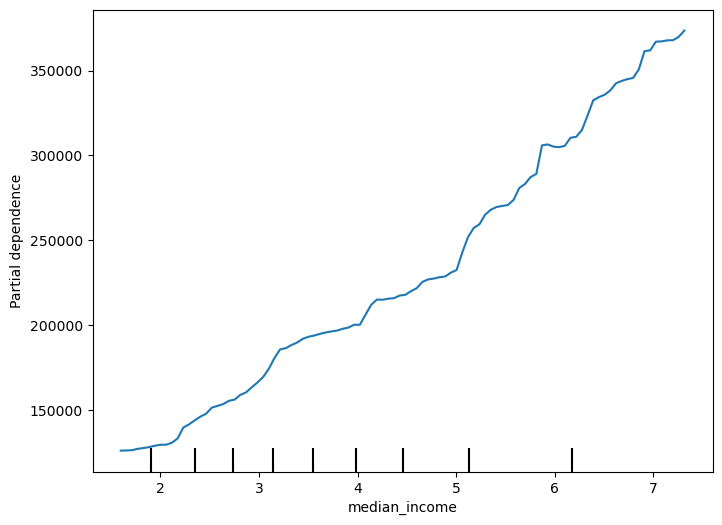

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(best_model, X_train, features=[7], ax=ax, feature_names=X_train.keys())
plt.show()

Dejas fijo la variable y haces predicciones sacando el promedio. Ves si incrementa, entonces la variable es bueno que suba. Por ejemplo le pones 2000 de income a todos y sacas el promedio de la predicción. LUego pone 3000 en income para todos y hace la predicción y sacas el promedio.

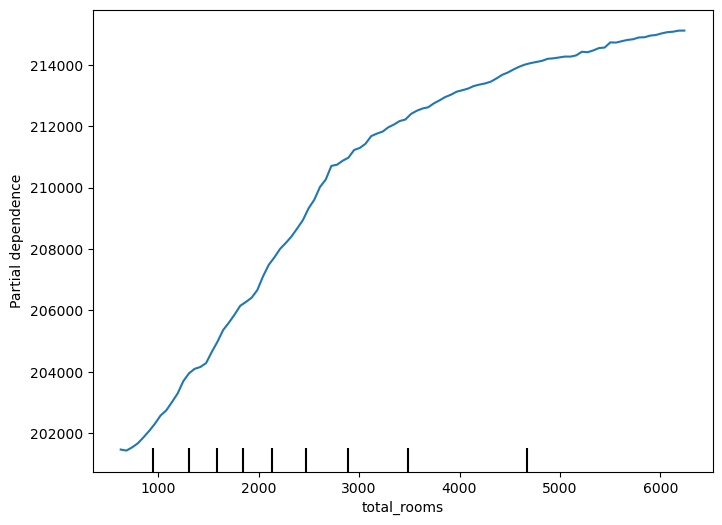

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(best_model, X_train, features=['total_rooms'], ax=ax);

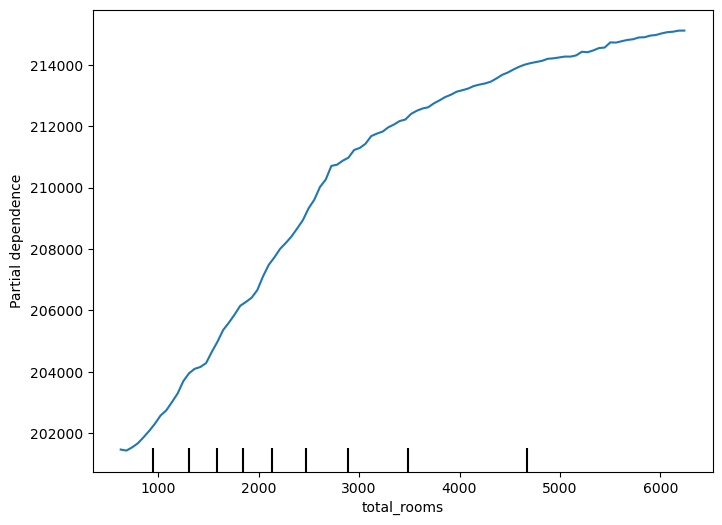

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(best_model, X_train, features=[3], ax=ax, feature_names=X_train.keys());

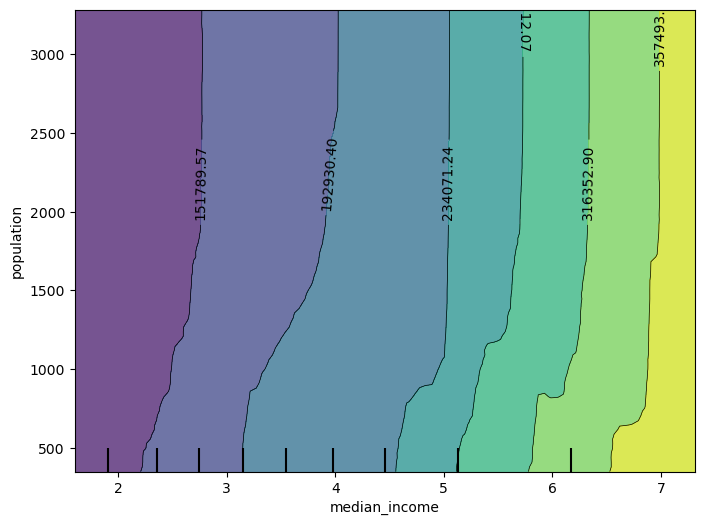

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(best_model, X_train, features=[(7,5)], ax=ax, feature_names=X_train.keys())
plt.show()

### Partial dependence 3D
PartialDependenceDisplay.from_estimator(best_forest, X_train, [(0, 1)], ax=ax, feature_names=X_train.keys())